In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [2]:
load_dotenv()
openai_model=ChatOpenAI(model="gpt-4")

In [3]:
openai_model.invoke("hi")

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [6]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [7]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003474648, 'queue_time': 0.046249952000000004, 'total_time': 0.061656466}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-eac971d0-74a3-46eb-9c55-939daa00a6ec-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [8]:
search_tool=DuckDuckGoSearchRun()

In [9]:
search_tool.invoke("what is a gdp of india?")

"2. What are the top 10 poorest countries in the world? The largest economy in Asia is China, with a nominal GDP of over $18,270 billion in 2025. Japan and India rank next to China in Asia's GDP ... In India, the GDP growth rate portrays the fluctuations in the adjusted value of goods and services produced by the country's economy over a given period. India, one of the most robust economies ... India is a front-runner among developing economies. Find out how India calculates its GDP, an indicator of economic health and performance. The growth rate in Real GDP during 2024-25 is estimated at 6.4% as compared to 8.2% in 2023-24. Nominal GDP or GDP at Current Prices is estimated to attain a level of ₹324.11 lakh crore in the year 2024-25, against ₹295.36 lakh crore in 2023-24, showing a growth rate of 9.7%. Brief Method of compiling Gross Domestic Product estimates by Industry 13.3.1 Broadly, the methodology for compiling the estimates of GDP consists in dividing the whole economy into var

In [10]:
repl=PythonREPL()

In [11]:
code = """
x = 5
y = x * 2
print(y)
"""

In [12]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [9]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [14]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [15]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [ ]:
"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [16]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [20]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
    )
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [21]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
    )
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [22]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

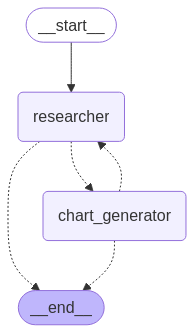

In [23]:
display(Image(app.get_graph().draw_mermaid_png()))

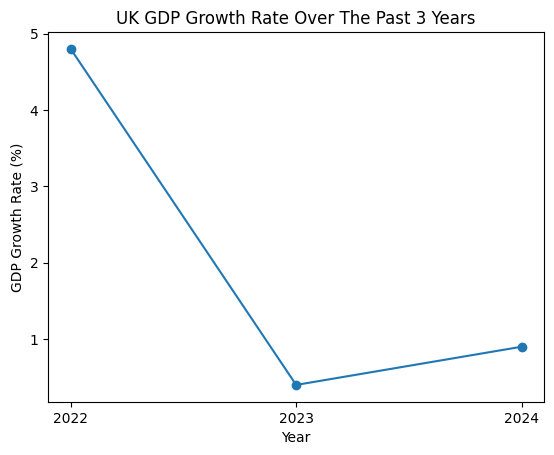

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='019b6e66-774e-4d95-9e50-09abdfafc0a9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4Ju8sqNadf8dqLLQq7U6cVgS', 'function': {'arguments': '{\n  "query": "UK\'s GDP over the past 3 years"\n}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 204, 'total_tokens': 231, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BDWtCq9rbBkAALKEaeKg73LUjlJEd', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b7d63a79-c1a5-4ef8-8c39-181c860bb1be-0', tool_calls=[

In [35]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})